<a href="https://colab.research.google.com/github/Dmytro-Meduza/course_project/blob/master/Course_project_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports and settings

In [3]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
import tensorflow as tf

# Define perceptual loss
def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(None, None, 3))
    vgg.trainable = False  # Freeze VGG16 layers
    # Extract features from a specific layer
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    true_features = feature_extractor(y_true)
    pred_features = feature_extractor(y_pred)
    return tf.reduce_mean(tf.square(true_features - pred_features))


# 2. Loading and preparing the data
Download and process DIV2K dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to the dataset
import os
DIV2K_DIR = "/content/drive/My Drive/DIV2K"
DIV2K_train_HR = os.path.join(DIV2K_DIR, "DIV2K_train_HR")
DIV2K_valid_HR = os.path.join(DIV2K_DIR, "DIV2K_valid_HR")

# Check if the folders exist
if not os.path.exists(DIV2K_train_HR):
    raise FileNotFoundError(f"Training folder not found: {DIV2K_train_HR}")
if not os.path.exists(DIV2K_valid_HR):
    print(f"Validation folder not found: {DIV2K_valid_HR}, proceeding with training data split.")

print("Paths are set correctly!")

def load_images(path, target_size=(256, 256)):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Filter for image files
            print(f"Loading {filename}...")  # Debugging
            img = load_img(os.path.join(path, filename), target_size=target_size)  # Load image
            img = img_to_array(img) / 255.0  # Normalize to range [0, 1]
            images.append(img)
    if not images:
        print("No images found!")
    return np.array(images)

def downscale_images(images, scale=2):

    LR_images = []
    for img in images:
        h, w, _ = img.shape
        LR = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_AREA)  # Downscale image
        LR_images.append(LR)
    return np.array(LR_images)

# Load training data
HR_images_train = load_images(DIV2K_train_HR)  # Load HR training images
LR_images_train = downscale_images(HR_images_train)  # Create LR training images

# Load validation data if available
if os.path.exists(DIV2K_valid_HR):
    HR_images_valid = load_images(DIV2K_valid_HR)  # Load HR validation images
    LR_images_valid = downscale_images(HR_images_valid)  # Create LR validation images
else:
    # If no validation data is available, split training data
    from sklearn.model_selection import train_test_split
    HR_images_train, HR_images_valid = train_test_split(HR_images_train, test_size=0.2, random_state=42)
    LR_images_train, LR_images_valid = train_test_split(LR_images_train, test_size=0.2, random_state=42)

# Apply data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images up to 15 degrees
    horizontal_flip=True,     # Apply horizontal flip
    vertical_flip=True        # Apply vertical flip
)

# Generate augmented data for training
batch_size = 32  # Define your batch size
HR_augmented = datagen.flow(HR_images_train, batch_size=batch_size, shuffle=True)
LR_augmented = datagen.flow(LR_images_train, batch_size=batch_size, shuffle=True)

# Check if variables are defined
print(f"HR_images_valid exists: {'HR_images_valid' in locals()}")
print(f"LR_images_valid exists: {'LR_images_valid' in locals()}")



# 3. Building the Super-Resolution model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add
from tensorflow.keras.optimizers import Adam

# Function to create the improved Super-Resolution model
def build_improved_model():
    inputs = Input(shape=(None, None, 3))

    # Initial convolution layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)

    # Residual block
    for _ in range(5):  # 5 Residual blocks
        residual = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        residual = Conv2D(64, (3, 3), activation='relu', padding='same')(residual)
        x = Add()([x, residual])  # Adding the residual connection

    # Upsampling
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Final output layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build and compile model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Create the improved model
model = build_improved_model()
model.summary()  # Display the model architecture


In [ ]:
print(f"HR_images_valid exists: {'HR_images_valid' in locals()}")
print(f"LR_images_valid exists: {'LR_images_valid' in locals()}")
!ls "/content/drive/My Drive/DIV2K/DIV2K_valid_HR"
DIV2K_valid_HR = os.path.join(DIV2K_DIR, "DIV2K_valid_HR")

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np




import cv2

def downscale_images(images, scale=2):

    LR_images = []
    for img in images:
        h, w, _ = img.shape
        LR = cv2.resize(img, (w // scale, h // scale), interpolation=cv2.INTER_AREA)  # Downscale image
        LR_images.append(LR)
    return np.array(LR_images)


# Load validation images
HR_images_valid = load_images(DIV2K_valid_HR)  # High-resolution validation images
LR_images_valid = downscale_images(HR_images_valid)  # Low-resolution validation images


# 4. Training the model

In [ ]:
def build_improved_model():
    inputs = Input(shape=(None, None, 3))

    # Initial convolution layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)

    # Residual block
    for _ in range(5):  # 5 Residual blocks
        residual = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        residual = Conv2D(64, (3, 3), activation='relu', padding='same')(residual)
        x = Add()([x, residual])  # Adding the residual connection

    # Upsampling
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Final output layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build model
    model = Model(inputs, outputs)

    # Compile with perceptual loss
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=perceptual_loss)
    return model



# 5. Testing the model
Compare results with cv2.resize

In [ ]:
from sklearn.model_selection import train_test_split

# Combine all data into single arrays
HR_images = np.concatenate([HR_images_train, HR_images_valid], axis=0)
LR_images = np.concatenate([LR_images_train, LR_images_valid], axis=0)

# Split data into training and validation sets
LR_train, LR_val, HR_train, HR_val = train_test_split(LR_images, HR_images, test_size=0.2, random_state=42)

# Train the model
batch_size = 32  # Batch size for training
epochs = 30      # Number of epochs for training

# Fit the model on the training data
history = model.fit(
    LR_train, HR_train,  # Low-resolution and high-resolution training pairs
    validation_data=(LR_val, HR_val),  # Validation data
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True
)



# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Training Progress')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


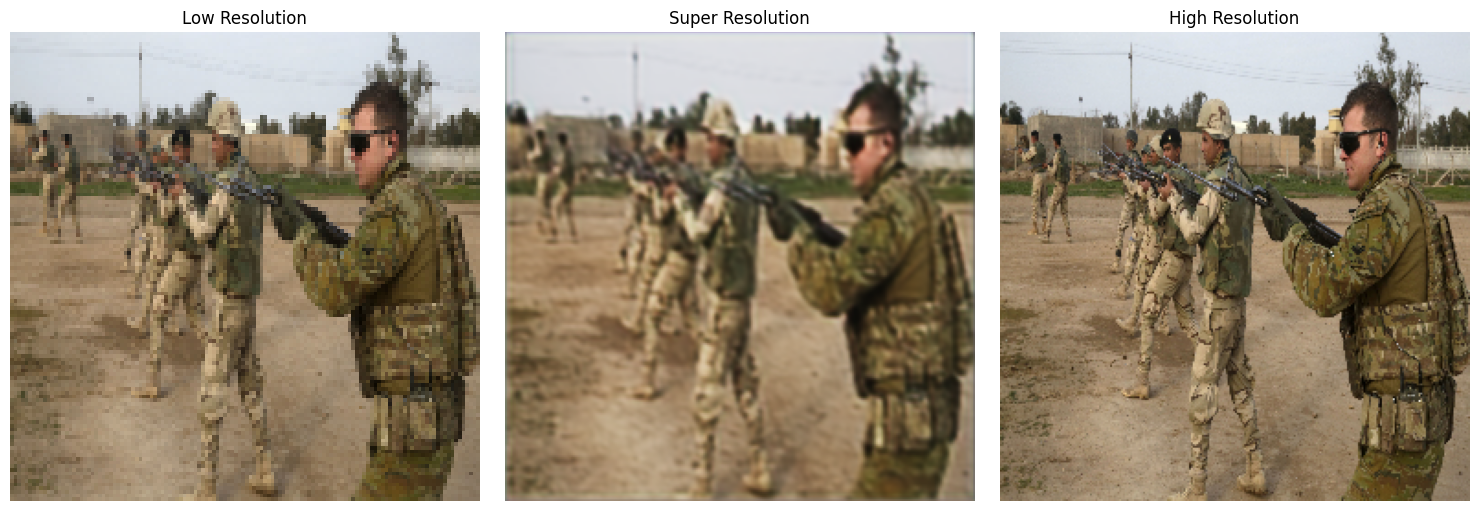

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


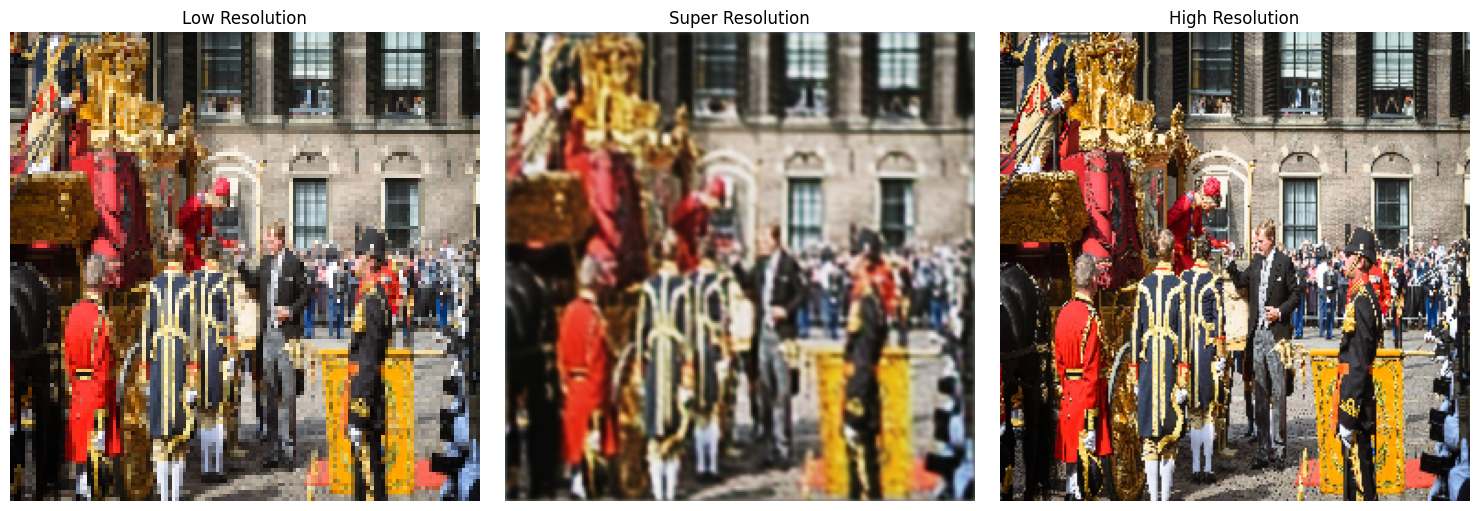

In [ ]:
# Test on a random validation sample
import numpy as np
index = np.random.randint(len(LR_val))  # Ensure LR_val exists and is defined
LR_sample = LR_val[index]
HR_sample = HR_val[index]






# Function to upscale an image using the trained model
def upscale_image(model, LR_image):
    LR_image = np.expand_dims(LR_image, axis=0)  # Add batch dimension
    LR_image = LR_image.astype('float32')  # Ensure correct type
    SR_image = model.predict(LR_image)[0]  # Predict and remove batch dimension
    SR_image = np.clip(SR_image * 255.0, 0, 255).astype('uint8')  # Denormalize
    return SR_image
# Apply Super-Resolution
SR_sample = upscale_image(model, LR_sample)

# Function to display results
def display_results(LR, SR, HR):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(LR)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(SR)
    axes[1].set_title("Super Resolution")
    axes[2].imshow(HR)
    axes[2].set_title("High Resolution")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display results
display_results(LR_sample, SR_sample, HR_sample)

# Apply traditional interpolation (cv2.resize)
interpolated_sample = cv2.resize(LR_sample, (HR_sample.shape[1], HR_sample.shape[0]), interpolation=cv2.INTER_CUBIC)

# Test on a random validation sample
index = np.random.randint(len(LR_val))
LR_sample = LR_val[index]
HR_sample = HR_val[index]

# Apply Super-Resolution
SR_sample = upscale_image(model, LR_sample)

# Apply traditional interpolation (cv2.resize)
interpolated_sample = cv2.resize(LR_sample, (HR_sample.shape[1], HR_sample.shape[0]), interpolation=cv2.INTER_CUBIC)

# Display results
display_results(LR_sample, SR_sample, HR_sample)


In [ ]:
# Save the trained model for future use
model.save("super_resolution_model.h5")